## Introduction to the Data Set

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which we'll be working with. The file contains 17,380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here are the descriptions for the columns:

- `instant` - A unique sequential ID number for each row
- `dteday` - The date of the rentals
- `season` - The season in which the rentals occurred (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- `yr` - The year the rentals occurred (0 = 2011, 1 = 2012)
- `mnth` - The month the rentals occurred (as a label, 1 to 12)
- `hr` - The hour the rentals occurred (as a label, 0 to 23)
- `holiday` - Whether or not the day was a holiday (extracted from [here](https://dchr.dc.gov/page/holiday-schedules))
- `weekday` - The day of the week (as a label, 0 to 6)
- `workingday` - Whether or not the day was a working day
- `weathersit` - The weather ( 1 = Clear, Few clouds, Partly cloudy, Partly cloudy, 2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist, 3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds, 4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog )
- `temp` - The temperature, on a 0-1 scale
- `atemp` - The adjusted 'feels like' temperature, on a 0-1 scale
- `hum` - The humidity, on a 0-1 scale
- `windspeed` - The wind speed, on a 0-1 scale
- `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- `registered` - The number of registered riders (people who had already signed up)
- `cnt` - The total number of bike rentals (casual + registered)

In [3]:
#Renaming columns for better understanding
rename_dict = {'dteday' : 'date', 
               'weathersit': 'weather'}
bike_rentals.rename(columns = rename_dict, inplace = True)
bike_rentals.head()

,instant,date,season,yr,mnth,hr,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Problem Statement

With this dataset, we will create a model to predict the total number of bikes people rented in a given hour. We will predict the `cnt` column using all of the other columns (if possible), except for `casual` and `registered`. These columns leak information from the future and may not be available with new data. We will drop the `yr` column as well, as new data will never have 2011 or 2012 as the year.

In [4]:
#dropping initial columns not needed for 
bike_rentals.drop(columns = ['casual', 'registered', 'yr'], inplace = True)

## Exploratory Data Analysis

Here we will explore the dataset through visualization and descriptive statistic tables. We will report any findings that may help or hinder the machine learning process.

In [5]:
#observing column type and for null values
print(bike_rentals.shape)
print('-'*20)
bike_rentals.info() 

(17379, 14)
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
instant       17379 non-null int64
date          17379 non-null object
season        17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: float64(4), int64(9), object(1)
memory usage: 1.9+ MB


**Findings**

There are no null values and all columns are numeric, except the dates. If there were missing values, we would have had to:
- impute the data with the mean or the mode of the column,
- drop columns if majority of the column was missing since it would add no value to the machine learning process, or
- drop rows if missing values are located randomly within the dataset and imputation is not possible.

The `season`, `month`, `hr`, `holiday`, `weekday`, `workingday`, & `weather` represent categorical values and should be treated as such. The `temp`, `atemp`, `windspead` and `hum` contain continuous data and need to be analyzed differently than the categorical columns.

In [6]:
# Observing general descriptive statistics of continuous columns
bike_rentals[['temp','atemp','hum','windspeed','cnt']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000
atemp,17379.0,0.475775,0.171850,0.00,0.3333,0.4848,0.6212,1.0000
hum,17379.0,0.627229,0.192930,0.00,0.4800,0.6300,0.7800,1.0000
windspeed,17379.0,0.190098,0.122340,0.00,0.1045,0.1940,0.2537,0.8507
cnt,17379.0,189.463088,181.387599,1.00,40.0000,142.0000,281.0000,977.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F184FEA6C8>,
      dtype=object)

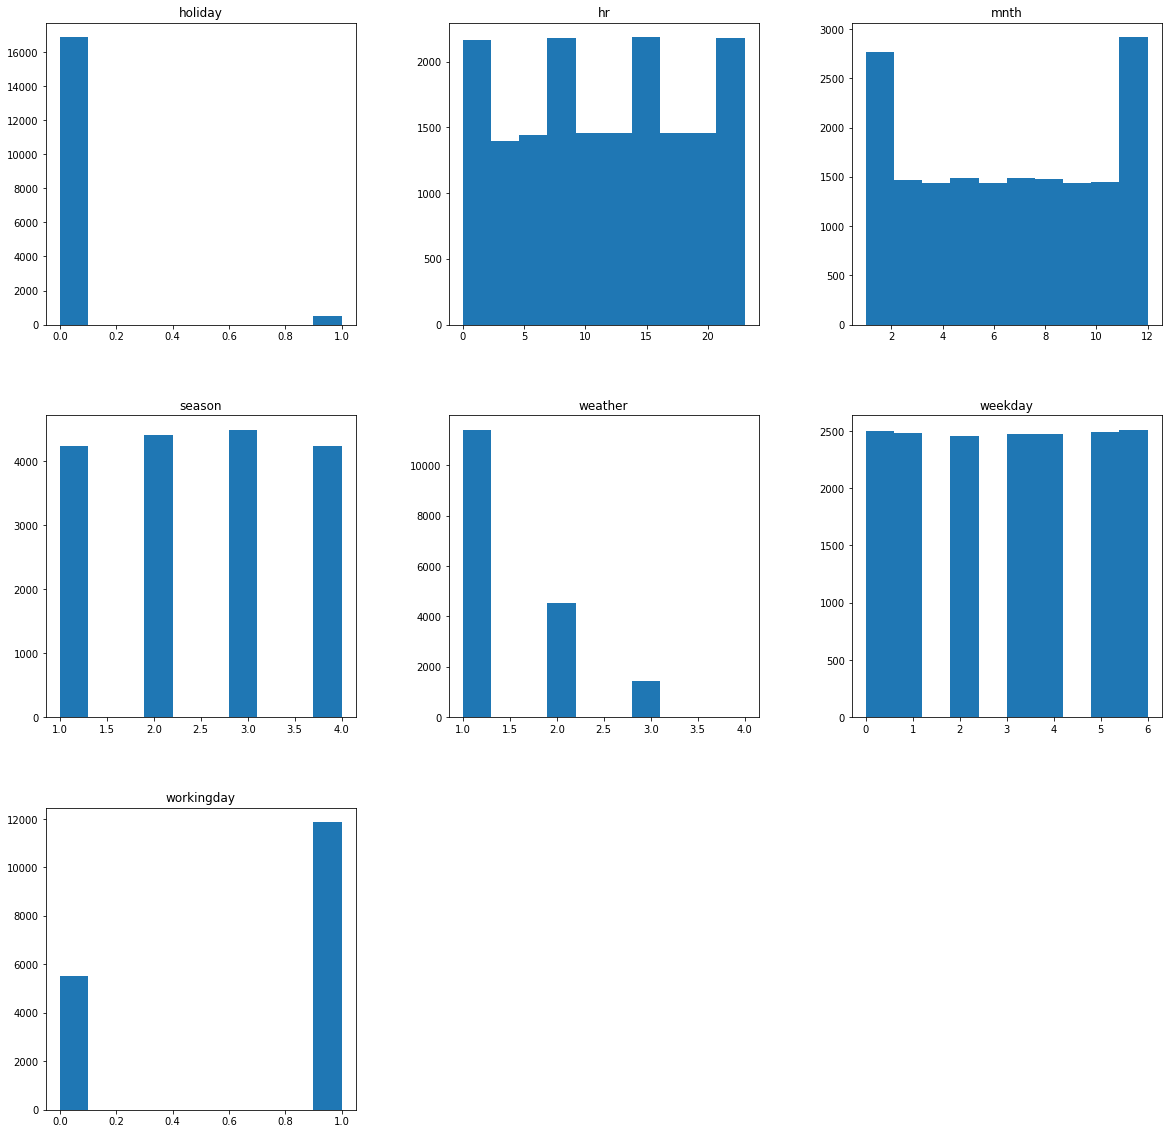

In [7]:
cat_cols = bike_rentals.select_dtypes(include = ['int64']).columns.drop(['instant', 'cnt'])
bike_rentals[cat_cols].hist(figsize = (20,20), grid = False)

In [8]:
bike_rentals['weather'].value_counts()

1    11413
2     4544
3     1419
4        3
Name: weather, dtype: int64

In [9]:
for col in cat_cols:
    bike_rentals[col] = bike_rentals[col].astype('category')
    
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
instant       17379 non-null int64
date          17379 non-null object
season        17379 non-null category
mnth          17379 non-null category
hr            17379 non-null category
holiday       17379 non-null category
weekday       17379 non-null category
workingday    17379 non-null category
weather       17379 non-null category
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
dtypes: category(7), float64(4), int64(2), object(1)
memory usage: 1.0+ MB


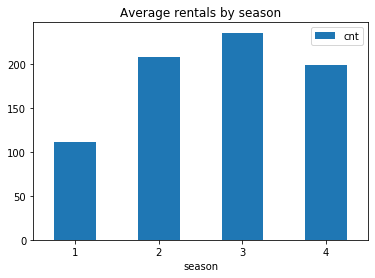

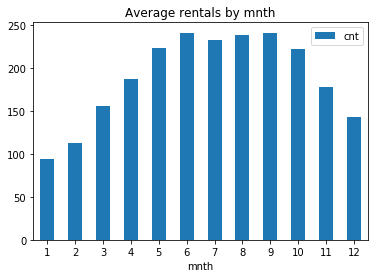

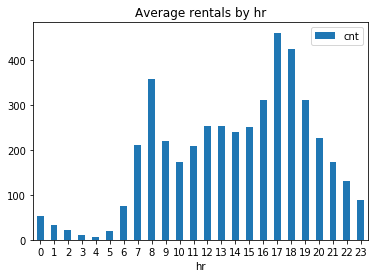

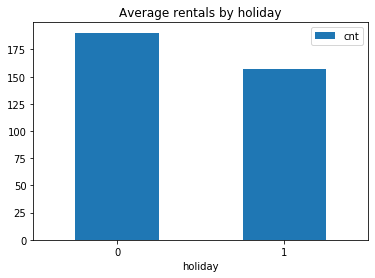

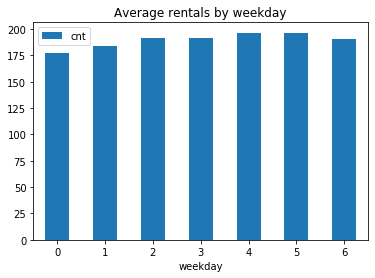

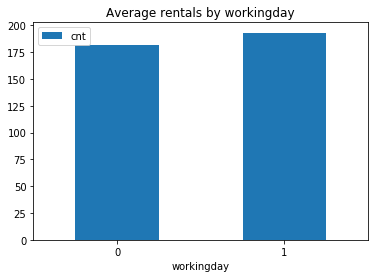

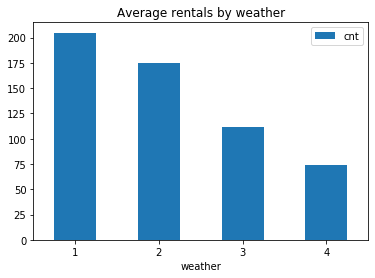

In [10]:
#observing categorical columns to find insights 
def plot_bar(col):
    '''Function returns a bar plot of rentals in bike_rentals dataframe 
    by the unique values in the column.
    
    Args:
        col - name of column
        
    Returns:
        Bar plot utlizing matplotlib library
    '''   
    grouped  = bike_rentals.pivot_table(index = col, values = 'cnt', aggfunc = np.mean)
    grouped.plot.bar(rot = 0, title = 'Average rentals by {}'.format(col))
    plt.show()

for col in cat_cols.tolist():
    plot_bar(col)

**Findings**

It is interesting to note that in the `season` column plot, Fall(3) has the highest average of rentals and Winter(4) has a higher average in rentals than in Spring(1). It would be helpful to find out how the seasons were divided up within the year.

The `mnth` column shows average rentals ascending every month from the beginning of the year until June. Then it plateaus until September before the average starts descending again. This data is congruent to heurestic observation as the months in the middle of the year tend to have better weather for outdoor activities in D.C. while the months at the beginning and end of the year have less than ideal weather.

The `hr` column plot shows that  5:00 PM(hour 17) has the highest rentals followed by 6:00 PM(hour 18) and then 8:00 AM(hour 8). This is mostly likely due to bikers renting and riding after getting out of work or riding prior to starting the work day.

According to the `holiday` column plot, the average rental is higher on a non-holiday vs on a holiday. This may be due to an imbalance in the values of the column as there are more non-holiday days than holidays in the year. 

There aren't any stand out values in the `weekday` column plot as the average rentals seem to be similar.

Days labeled as a `workingday` have higher average rentals than non-workday, though not by much.

The `weather` column show average rentals descending by the categorical values. This makes sense as weather category 1 signifies clear or partly cloudly skies which are ideal conditions for outdoor activities, whereas category 4 signifies heavy rain, thunderstorm, or fog which are not so ideal conditions for outdoor acitivies.

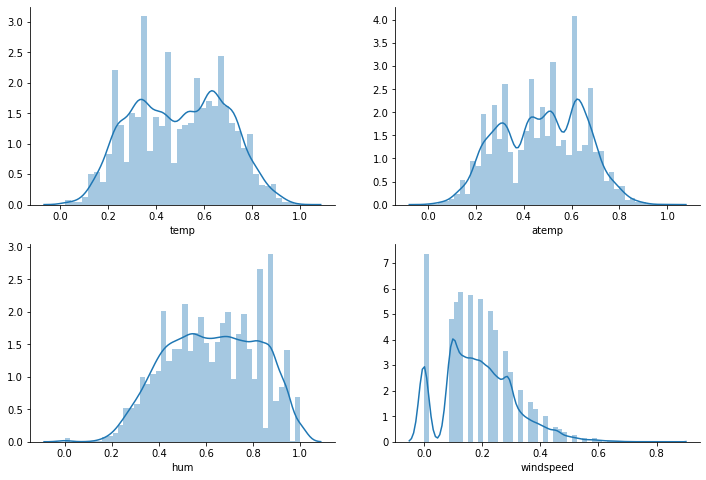

In [11]:
#Observing continuous data columns for insights
cont_cols = bike_rentals.select_dtypes(include = ['float64']).columns

def plot_dist(cols):
    '''Plots distribution of given columns in bike_rental dataframe'''
    n_rows = int(np.ceil(len(cols)/2))
    n_cols = int(np.floor(len(cols)/ 2))
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (12,8))
    axes = axes.flatten()
    for col,ax in zip(cols, axes):
        sns.distplot(bike_rentals[col], ax = ax)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

plot_dist(cont_cols.tolist())

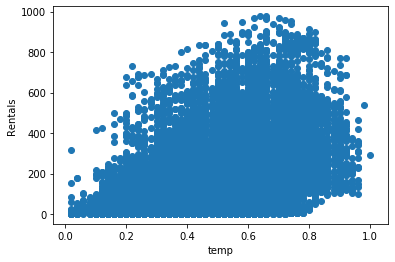

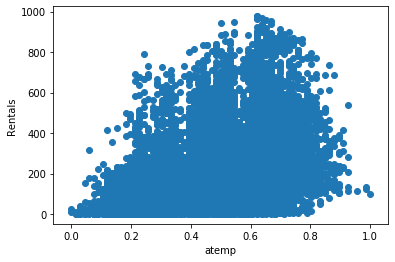

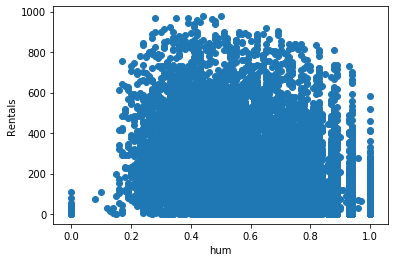

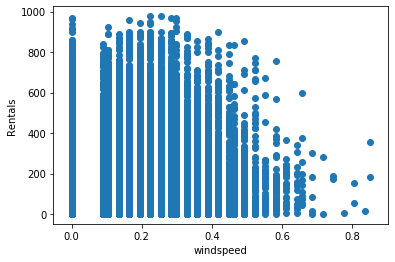

In [12]:
def plot_scatter(col):
    '''Plots scatter plot of given column against `cnt` column in the bike_rentals dataframe'''
    plt.scatter(x = bike_rentals[col], y = bike_rentals['cnt'])
    plt.xlabel(col)
    plt.ylabel('Rentals')
    plt.show()
    
for col in cont_cols.tolist():
    plot_scatter(col)

windspeed    0.093234
hum          0.322911
atemp        0.400929
temp         0.404772
cnt          1.000000
Name: cnt, dtype: float64


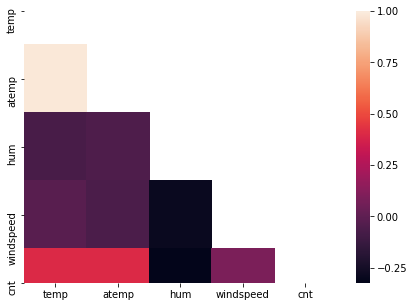

In [13]:
corr_cols = cont_cols.tolist()
corr_cols.append('cnt')

rental_corr = bike_rentals[corr_cols].corr()

matrix = np.triu(rental_corr)
f, ax = plt.subplots(figsize = (7,5))
sns.heatmap(rental_corr, mask = matrix)
print(rental_corr['cnt'].abs().sort_values(ascending = True)) #absolute correlation of rentals to continuous data columns

**Findings**

Distributions of `temp`, `atemp`, and `hum` follow approximately a normal distribution, while `windspeed` shows a right skewed distribution.

According to the scatter plots, `temp` and `atemp` show simliar relations to `cnt`(rentals). Rentals tend to be low with high `windspeed` or with low `hum`(humidity). 

There doesn't seem to be any correlation among the continuous data columns except `temp` and `atemp`(which is to be expected).
`temp` and `atemp` have the highest absolute correlation with `cnt` of around 0.4.

We will check the `cnt` distribution for any insights.

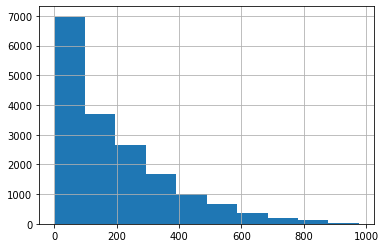

In [14]:
bike_rentals['cnt'].hist(bins = 10)

The distribution of rentals follow a right skewed distribution.
In any given hour, the number of rentals is mostly likely in between 0 - 100. 

### EDA Summary

We have utilized visualization and compared our findings to domain knowledge to verify the data. If there were to be any unusual or corrupt data, we would have had to analyze further and remove the invalid data to our best ability.

---
## Creating Features

The `hr` column in bike_rentals contains the hours during which bikes are rented, from 0 to 23. Dummy coding this column will create excessive number of columns. Also, a machine will treat each hour differently, without understanding that certain hours are related. We will introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night.

In [15]:
def assign_label(hour):
    '''Grouping hours by the time of day.
    
    1 = Morning(6 AM to 12 PM)
    2 = Afternoon(12PM to 6 PM)
    3 = Evening(6 PM to 12 AM)
    4 = (12 AM to 6 AM)
    
    '''
    if hour >= 0 and hour < 6:
        return 4
    elif hour >= 6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <= 24:
        return 3
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals['time_label'] = bike_rentals['time_label'].astype('category')
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
instant       17379 non-null int64
date          17379 non-null object
season        17379 non-null category
mnth          17379 non-null category
hr            17379 non-null category
holiday       17379 non-null category
weekday       17379 non-null category
workingday    17379 non-null category
weather       17379 non-null category
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
cnt           17379 non-null int64
time_label    17379 non-null category
dtypes: category(8), float64(4), int64(2), object(1)
memory usage: 1.1+ MB


In [16]:
# cat_cols = bike_rentals.select_dtypes(include = ['category']).columns.tolist()
# cat_cols.remove('workingday')
# cat_cols.remove('holiday')

# dummy = pd.DataFrame()

# for col in cat_cols:
#     dummy = pd.get_dummies(bike_rentals[col])
#     bike_rentals = pd.concat([bike_rentals, dummy], axis = 1)
#     bike_rentals.drop(columns = col, inplace = True)

# print(bike_rentals.shape)
# print('-'*20)
# bike_rentals.head()

**EDIT**

We attempted to encode the categorical columns and create dummy columns with binary variables for the machine learning process. However, after model creation and analysis it was confirmed the new columns did not add value and rather increased the runtime. For this reason, we decided to comment out this task but would like to show that it was considered.

---

## Creating Train & Test Data sets

We will be treating each observation in the dataset as independent of each other, instead of sequential as the `date` column suggests. For this reason we will be dropping the `date` column. We will be random sampling our dataset to create the train and test dataset.  

### Error Metric

Since we will be training different models we will be using MSE as our error metric for continuous numeric data to compare the models. MSE was chosen over MAE or RMSE as MSE displays the gap between the predicted and actual values more clearly(by squaring the difference). We may display the RMSE of our best model to observe how far off in rentals we can expect the model to perform since the RMSE value has the same unit as the target column.

In [17]:
train = bike_rentals.sample(frac = 0.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [18]:
def plot_err_diff(predictions):
    '''Plots histograms of actual rentals vs predicted rentals for comparison.
    Args:
        predictions - predicted values from a given model
    Returns:
        2 histograms of actual and predicted values
    '''
    fig, ax = plt.subplots(1,2, figsize = (10,5))
    ax[0].hist(bike_rentals['cnt'], bins = 10)
    ax[0].set_title('Actual Rentals')

    ax[1].hist(predictions, bins = 10)
    ax[1].set_title('Predicted Rentals')
    plt.show()

## Poisson Regression

Poisson Regression is chosen as a baseline model as `cnt` is count data.

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import glm

drop_cols = ['instant', 'date']
poisson_train = train.drop(columns = drop_cols)
features = poisson_train.columns.tolist()
features

['season',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'cnt',
 'time_label']

In [23]:
formula = '''cnt ~ C(season) + C(mnth) + C(hr) + C(holiday) + C(weekday) + C(workingday) + C(weather) + temp + atemp + hum + windspeed '''
pm = glm(formula, data = poisson_train, family = sm.families.Poisson()).fit()
predictions = pm.predict(test[features])
pm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    cnt   No. Observations:                13903
Model:                            GLM   Df Residuals:                    13851
Model Family:                 Poisson   Df Model:                           51
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4395e+05
Date:                Tue, 10 Mar 2020   Deviance:                   5.9902e+05
Time:                        21:16:03   Pearson chi2:                 6.07e+05
No. Iterations:                    37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.3061      0.007    442.218      0.000       3.291       3.321
C(season)[T.2]         0.2909      0.004     70.529      0.000       0.283       0.299
C(season)[T.3]         0.2706      0.005     57.832      0.000       0.261       0.280
C(season)[T.4]         0.4691      0.005    103.331      0.000       0.460       0.478
C(mnth)[T.2]           0.0915      0.004     21.648      0.000       0.083       0.100
C(mnth)[T.3]           0.1686      0.004     38.135      0.000       0.160       0.177
C(mnth)[T.4]           0.1014      0.006     17.189      0.000       0.090       0.113
C(mnth)[T.5]           0.1370      0.006     22.204      0.000       0.125       0.149
C(mnth)[T.6]           0.0455      0.006      7.205      0.000       0.033       0.058
C(mnth)[T.7]          -0.0541      0.007     -7.880      0.000      -0.068      -0.041
C(mnth)[T.8]           0.0639      0.007      9.571      0.000       0.051       0.077
C(mnth)[T.9]           0.1863      0.006     30.333      0.000       0.174       0.198
C(mnth)[T.10]          0.1071      0.006     17.666      0.000       0.095       0.119
C(mnth)[T.11]         -0.0054      0.006     -0.898      0.369      -0.017       0.006
C(mnth)[T.12]          0.0140      0.005      2.660      0.008       0.004       0.024
C(hr)[T.1]            -0.4295      0.009    -47.386      0.000      -0.447      -0.412
C(hr)[T.2]            -0.8395      0.011    -79.708      0.000      -0.860      -0.819
C(hr)[T.3]            -1.5197      0.014   -109.564      0.000      -1.547      -1.493
C(hr)[T.4]            -2.0814      0.018   -115.863      0.000      -2.117      -2.046
C(hr)[T.5]            -0.9336      0.011    -85.066      0.000      -0.955      -0.912
C(hr)[T.6]             0.4016      0.007     54.049      0.000       0.387       0.416
C(hr)[T.7]             1.4208      0.006    223.939      0.000       1.408       1.433
C(hr)[T.8]             1.9062      0.006    313.335      0.000       1.894       1.918
C(hr)[T.9]             1.3658      0.006    216.001      0.000       1.353       1.378
C(hr)[T.10]            1.0937      0.006    169.039      0.000       1.081       1.106
C(hr)[T.11]            1.2353      0.006    194.132      0.000       1.223       1.248
C(hr)[T.12]            1.3929      0.006    221.233      0.000       1.381       1.405
C(hr)[T.13]            1.3741      0.006    217.409      0.000       1.362       1.386
C(hr)[T.14]            1.2800      0.006    200.630      0.000       1.267       1.292
C(hr)[T.15]            1.3422      0.006    210.339      0.000       1.330       1.355
C(hr)[T.16]            1.5514      0.006    248.772      0.000       1.539       1.564
C(hr)[T.17]            1.9805      0.006    325.173      0.000       1.969       1.992
C(hr)[T.18]            1.9187      0.0

In [24]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['cnt'], predictions)
print('MSE:', mse)

MSE: 10640.489964644607


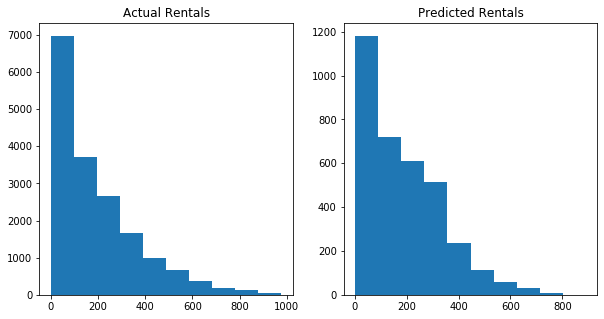

In [25]:
plot_err_diff(predictions)

The error is high. MSE always emphasizes significant errors as bigger. We will have to try different approaches to lower the MSE.

## Decision Trees

Decision Tree Regression chosen to capture non-linearity.

In [21]:
from sklearn.tree import DecisionTreeRegressor

n_leaves = [1, 2, 5, 10, 20]
mses = []
for n in n_leaves:
    dtr = DecisionTreeRegressor(min_samples_leaf = n, random_state = 2)
    dtr.fit(train[features], train['cnt'])
    predictions = dtr.predict(test[features])
    mse = mean_squared_error(test['cnt'], predictions)
    mses.append(mse)

mses_dict = {}
for n, mse in zip(n_leaves, mses):
    mses_dict[n] = mse

mses_dict

{1: 9008.06422612198,
 2: 7872.224569668201,
 5: 6575.56274138386,
 10: 5882.613800342915,
 20: 5914.381166162582}

<function matplotlib.pyplot.show(*args, **kw)>

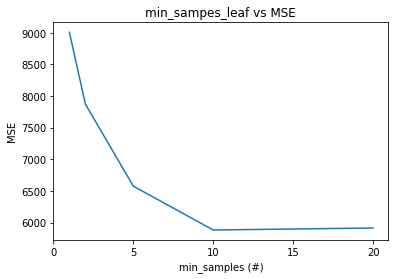

In [22]:
plt.plot(n_leaves, mses)
plt.title('min_sampes_leaf vs MSE')
plt.xlabel('min_samples (#)')
plt.xticks(np.arange(0, 21, step=5))
plt.ylabel('MSE')
plt.show

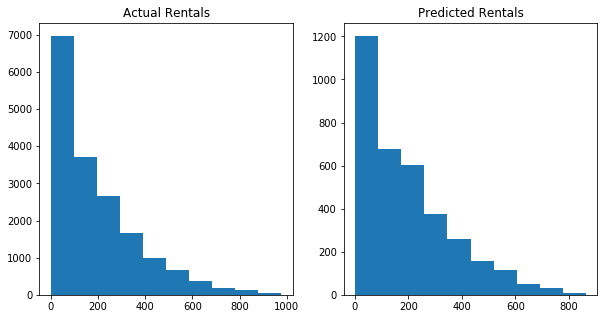

In [23]:
dtr = DecisionTreeRegressor(min_samples_leaf = 20, random_state = 2)
dtr.fit(train[features], train['cnt'])
dt_predictions = dtr.predict(test[features])
plot_err_diff(dt_predictions)

Decision Tree regressor show lower error than the Linear Regressor. This is because the descision tree regressor can account for non linearity in the data. The distribution of predicted and actual rentals both show right skewed distribution, which is a step towards the right direction.

After experimenting with different inputs for the `min_samples_leaf` parameter, we seem to get the lowest MSE when `min_samples_leaf` = 10. As we increase `min_samples_leaf`, we decrease variance, however we also increase bias. 

## Random Forests

The random forest algorithm is a powerful tool to reduce overfitting in decision trees.
Random forest is an ensemble algorithm that combines the predictions of multiple decision trees to create a more accurate final prediction. However, it is very computationaly expensive.

We will also use Grid Search for hyperparameter optimization. This method runs models for every combination of hyperparameters and finds the model with the combination with the lowest error. This is very computationally expensive and not always recommended.

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

hyperparameters = {'max_depth' : [None, 5, 10],
                   'min_samples_leaf' : [1, 5, 10],
                   'n_estimators' : [10, 20]
                  }
rf = RandomForestRegressor(random_state = 2)
grid = GridSearchCV(rf, param_grid = hyperparameters, cv = 10)
grid.fit(bike_rentals[features], bike_rentals['cnt'])

grid.best_params_

{'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 20}

Random Forest MSE: 5042.723185503625
Random Forest RMSE: 71.01213407230925


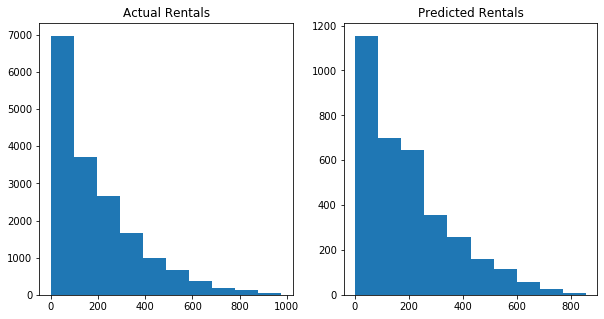

In [25]:
best_rf = grid.best_estimator_
best_rf.fit(train[features], train['cnt'])
rf_predictions = best_rf.predict(test[features])
mse = mean_squared_error(test['cnt'], rf_predictions)
rmse = mse**0.5

print('Random Forest MSE:', mse)
print('Random Forest RMSE:', rmse)
plot_err_diff(rf_predictions)

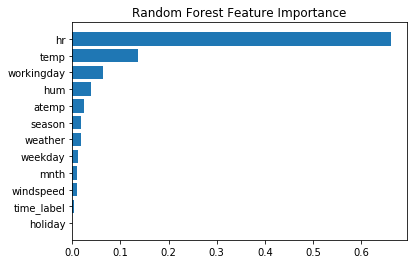

In [26]:
#observing the importance of all the features
rf_features = pd.DataFrame({'Features': features, 
                                     'Importance': best_rf.feature_importances_}).sort_values('Importance',
                                                                                            ascending = True)
plt.barh(rf_features['Features'], rf_features['Importance'])
plt.title('Random Forest Feature Importance')
plt.show()

The lowest MSE was achieved through Random Forest Regressor and model tuning. With 20 decision trees in the forest (`n_estimators = 20`) the accuracy has increased as overfitting is reduced. The `hr` column is the feature that allows the most information gain. The RMSE is 71.0 and considering the average for `cnt` (target column) is 189.5 and a standard deviation of 181.4, this is a promising model. However, there is still room for improvement. 

---
## Conclusion

We see an improvement of the error as we utilize Random Forest model with hyperparameter optimization. 

There is still room for implementing different methods to lower error:

- utilizing XGBoosting which is another ensemble tree method that applies the principal of boosting.
- applying Principal Component Analysis(PCA) to reduce dimensionality.

It would be interesting to predict the `casual` and `registered` rentals instead of `cnt` and see how they differ.
We could also use the `date` and predict rentals in a sequential manner using LSTM rather than each hour as independent.